<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />


# Worksheet 7.0 Anomaly Detection - Answers

This worksheet covers concepts relating to Anomaly Detection.  It should take no more than 20-30 minutes to complete.  Please raise your hand if you get stuck.  

There are many ways to accomplish the tasks that you are presented with, however you will find that by using the techniques covered in class, the exercises should be relatively simple. 

## Import the Libraries
For this exercise, we will be using:
* Pandas (http://pandas.pydata.org/pandas-docs/stable/)
* Numpy (https://docs.scipy.org/doc/numpy/reference/)
* Matplotlib (http://matplotlib.org/api/pyplot_api.html)
* PyFlux (https://pyflux.readthedocs.io/en/latest/)

**Note:  At the time of writing, PyFlux can be difficult to install with Python 3.7.  This module can be run with either `PyFlux` or `StatsModels`** 


In [1]:
import pandas as pd
import numpy as np
import pyflux as pf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import style
from pandas.plotting import autocorrelation_plot
style.use("ggplot")
%matplotlib inline

# Part One:  Finding Anomalies in CPU Usage Data
The first part of this lab, you will be examining CPU usage data to find anomalies. 

## Step One:  Get the Data
For this example, we will be looking at CPU Utilization Data to see if we can identify periods of unusual activity.  The data can be found in several files:

* `cpu-full-a.csv`:  A full set of CPU usage data without anomalies
* `cpu-train-a.csv`:  The training set from data set A
* `cpu-test-b.csv`:  The test set from data set A
* `cpu-full-b.csv`:  A full set of CPU usage data with an anomaly
* `cpu-train-b.csv`:  The training set from data set A
* `cpu-test-b.csv`:  The test set from data set A


This dataset is from examples in *Machine Learning & Security*  by Clarence Chio and David Freeman.  https://github.com/oreilly-mlsec/book-resources/tree/master/chapter3/datasets/cpu-utilization.

First let's take a look at the data set A.  For the first part of this lab, load the training dataset into a dataframe.  DataFrames have an option `infer_datatime_format` which, when set to `True`, will automatically infer dates. Setting this will save time and steps in data preparation. 

Once the data is loaded, call the usual series of exploratory functions and most importantly, plot the data.

In [2]:
df = pd.read_csv('../data/cpu-train-a.csv', parse_dates=[0], infer_datetime_format=True)

In [3]:
df.describe()

,cpu
count,420.000000
mean,1.233262
std,0.505668
min,0.570000
25%,0.787500
50%,1.110000
75%,1.582500
max,2.550000


In [4]:
df.sample(5)

,datetime,cpu
14,2017-01-27 18:56:00,0.99
392,2017-01-28 01:14:00,2.40
252,2017-01-27 22:54:00,1.87
347,2017-01-28 00:29:00,0.70
146,2017-01-27 21:08:00,1.10


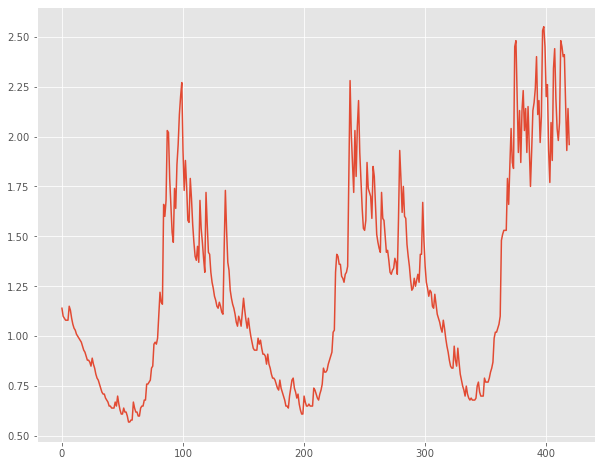

In [5]:
df['cpu'].plot(figsize=(10,8))

## Step Two:  Fit an ARIMA Model
Since we are dealing with time series data, let's train an ARIMA model and see how well this technique fits the actual data. 

ARIMA has three parameters:

* `p` (`ar`):  The number of lag observations included in the model
* `d` (`integ`): The number of times the raw observations are differenced
* `q` (`ma`):  The size of the moving average window

For the ARIMA model, use 11 for both the `ar` and `ma` parameters, and 0 for the `integ` parameter. The `ARIMA` function in PyFlux has a series of functions 

PyFlux has a series of plotting functions to visualize the model's performance including:

* `plot_fit()`:  This plot compares the fit of the ARIMA model with the actual data
* `plot_predict_is()`: This plot compares the predictions with the data. 
* `plot_predict()`: This plot compares the predictions and the confidence of the predictions

Run these all these plots on your model and see how well it forecasts the data.

Full documentation available here: https://pyflux.readthedocs.io/en/latest/arima.html

In [9]:
model = pf.ARIMA(data=df, ar=11, ma=11, integ=0, target='cpu')
x = model.fit("M-H")

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.1377
Acceptance rate of Metropolis-Hastings is 0.21355
Acceptance rate of Metropolis-Hastings is 0.1653
Acceptance rate of Metropolis-Hastings is 0.3985

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.265775


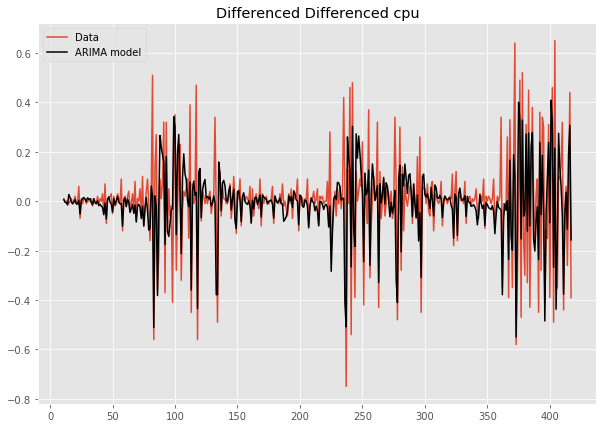

In [8]:
model.plot_fit()

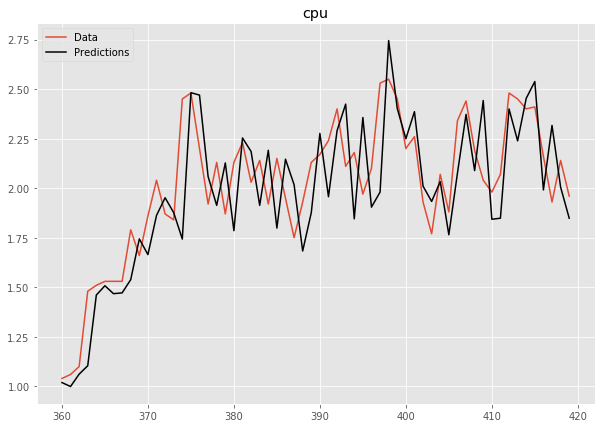

In [9]:
model.plot_predict_is(h=60)

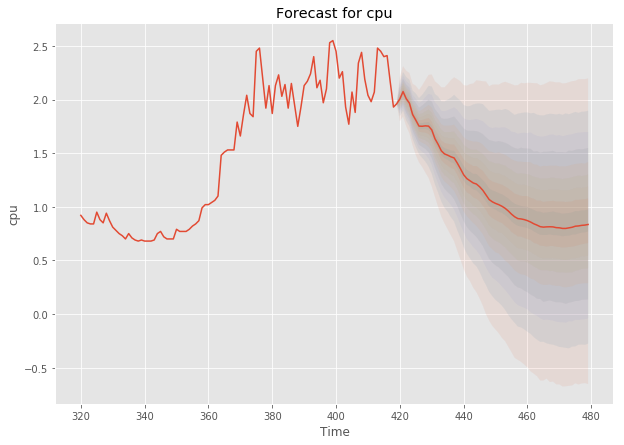

In [25]:
model.plot_predict(h=60, past_values=100)

## Step Three:  Find Anomalies in the CPU data
Using data set `B` train a new model. Once you have a trained model, the next step is to call the `.predict()` method to generate 60 predictions.  

Next, compare the predictions with the actual values in the test set, similar to how we assess the accuracy of a classifier.  We will call the difference between the actual and predicted value the anomaly score.  Calculate the anomaly score for the test data.  Finally, plot the anomaly scores, and see if you can find the time intervals with the highest anomaly score. 

In [10]:
df2_train = pd.read_csv('../data/cpu-train-b.csv', parse_dates=[0], infer_datetime_format=True)
df2_test = pd.read_csv('../data/cpu-test-b.csv', parse_dates=[0], infer_datetime_format=True)

In [17]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  600 non-null    datetime64[ns]
 1   cpu       600 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.5 KB


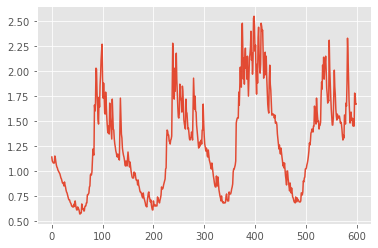

In [18]:
df2_train['cpu'].plot()

In [19]:
model2 = pf.ARIMA(data=df2_train, ar=11, ma=11, integ=0, target='cpu')
x = model2.fit("M-H")

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.01675
Acceptance rate of Metropolis-Hastings is 0.1409
Acceptance rate of Metropolis-Hastings is 0.1807
Acceptance rate of Metropolis-Hastings is 0.20935
Acceptance rate of Metropolis-Hastings is 0.19195
Acceptance rate of Metropolis-Hastings is 0.3377

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.29235


In [24]:
predictions = model2.predict(h=60)

In [27]:
df2_test.head()

,datetime,cpu,predictions,delta
0,2017-01-28 04:42:00,1.71,1.612359,0.097641
1,2017-01-28 04:43:00,1.58,1.579199,0.000801
2,2017-01-28 04:44:00,1.86,1.590890,0.269110
3,2017-01-28 04:45:00,1.66,1.594620,0.065380
4,2017-01-28 04:46:00,1.61,1.588251,0.021749


In [26]:
df2_test['predictions'] = predictions.reset_index(drop=True)
df2_test['delta'] = df2_test['cpu'] - df2_test['predictions']

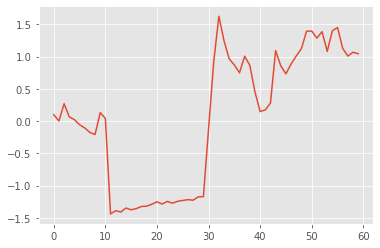

In [28]:
df2_test['delta'].plot()

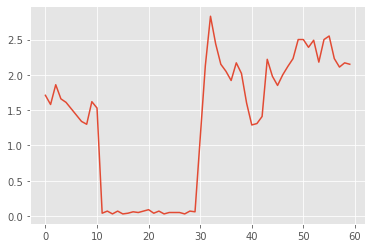

In [29]:
df2_test['cpu'].plot()

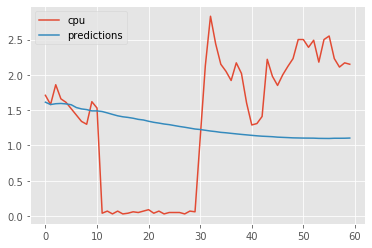

In [30]:
df2_test[['cpu','predictions']].plot()

## Conclusion:
If all went well, you should see anomalous behavior at 10 seconds into the test data.  Remembering that the forecasting's confidence goes down over time, the first anomaly should be enough to throw an alert for investigation. 